In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE, MDS
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def preprocess(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

In [32]:
# load and randomize

yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1.)
movies = pd.read_csv('sentiment/movies.csv').sample(frac=1.)

## Inspecting p(X) of the BOW vectorizers

Assuming that our data consists of discrete features, as in the Bag of Words models we have seen so far, visualizing $p(X)$ consists of visualizing the PMF of a multionomial distribution that consists of all the features in our data. 

Of course, this is a very wide distribution, even if we just include unigrams. 

Thus, we will visualize just the most popular features. 

We will see how, given the most popular features of one dataset, the other dataset compares. 

In [4]:
from copy import deepcopy

def _train_and_transform(vectorizer, X):
    vectorizer.fit(X)
    return vectorizer, vectorizer.transform(X)

def compare(vectorizer, A, B):
    vec_A, VA = _train_and_transform(deepcopy(vectorizer), A) 
    vec_B, VB = _train_and_transform(deepcopy(vectorizer), B) 

    # Get the most popular words for A
    # ignoring the top 25 super common
    # words
    sums = np.array(VA.sum(0)).reshape(-1)
    tops = np.argsort(sums)[-325:-25]
    freqs_A = sums[tops]

    features = np.array(vec_A.get_feature_names())[tops]

    idxs = np.array([vec_B.vocabulary_.get(s) for s in features])
    sums = np.array(VB.sum(0)).reshape(-1)
    freqs_B = [sums[i] if i else 0. for i in idxs]

    return pd.concat([pd.DataFrame({ 'word': features, 'dataset': d, 'freq': f }) 
                      for d,f in [('A',freqs_A), ('B',freqs_B)]])

In [5]:
vectorizer = TfidfVectorizer(preprocessor = preprocess, min_df = 1, use_idf=False)
df = compare(vectorizer, yelps.sample(500).text, movies.sample(500).text)

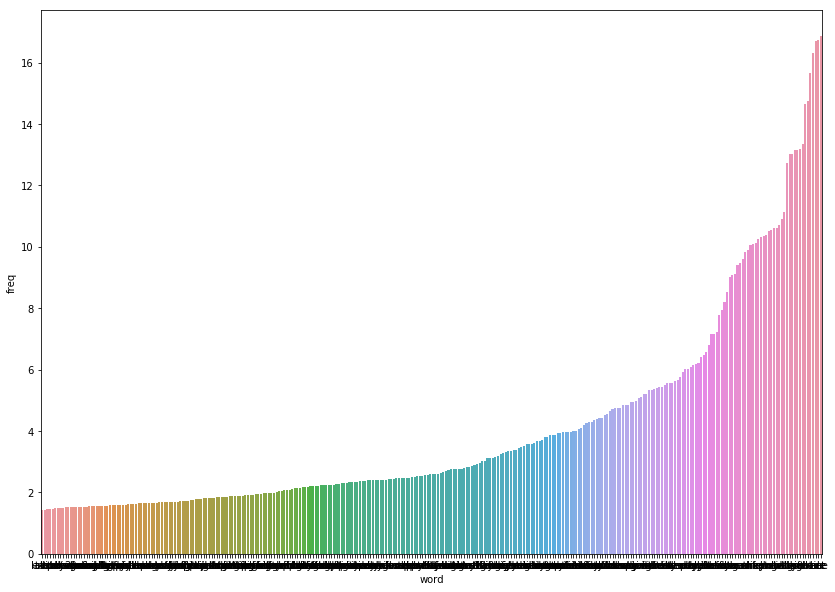

In [8]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'A']);

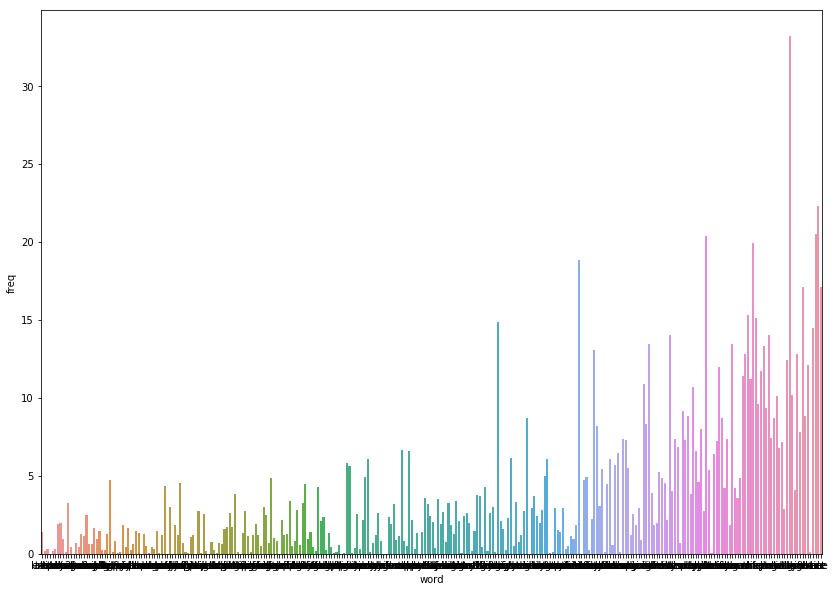

In [10]:
sns.barplot(x = 'word', 
            y = 'freq', 
            data = df[df.dataset == 'B']);

## Generative vs. Discriminative

Play around with the following plotting function. Is this consisten with the theoretical results of Ng and Jordan? Can you get the opposite results? Why? 

In [11]:
# Vectorizing the Yelp texts
vec_Yelp, V_Yelp = _train_and_transform(deepcopy(vectorizer),yelps.text)

/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserWarning: "https://www.consumeraffairs.com/news/mypillow-gets-a-rude-awakening-as-the-better-business-bureau-gives-it-an-f-010517.html" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'..'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/home/adam/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:335: UserW

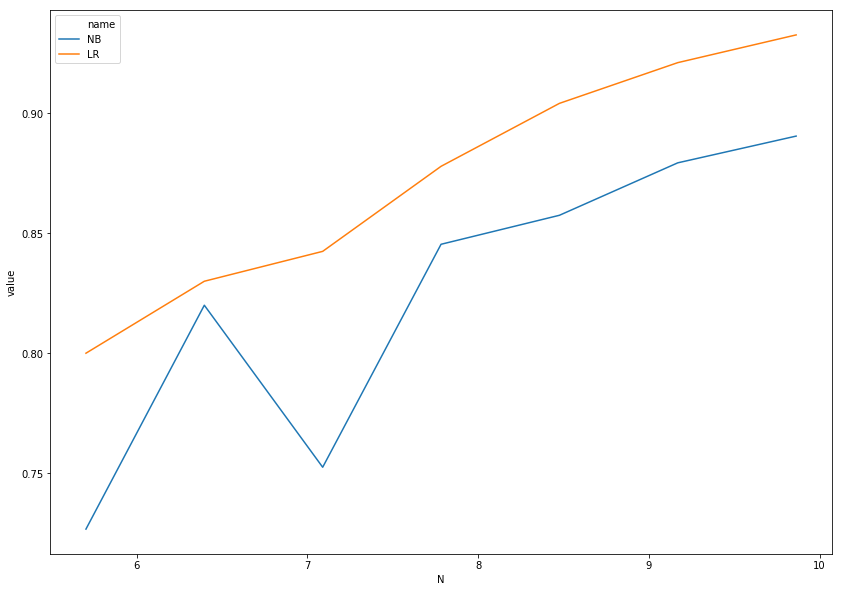

In [12]:
# add vectors here
V = V_Yelp
y = yelps.positive

def _cv_score(V, y, models):
    return [{ 'name': name, 'value': np.mean(cross_val_score(model, V, y, cv=3)) }
            for name, model in models]

def plot_cv_scores(V, y, models, ticks):
    scores = [_cv_score(V[:t], y[:t], models) for t in ticks]        
    scores = [({'N': np.log(t) , **i}) for t,s 
              in zip(ticks, scores) for i in s]
    df = pd.DataFrame(scores)
    return sns.lineplot(y='value', x='N', hue='name', data=df)

models = [('NB', MultinomialNB(fit_prior=False)), 
          ('LR', LogisticRegression(solver="lbfgs"))]

# Plotting cross validated scores
plot_cv_scores(V, y, models, [300, 600, 1200, 2400, 4800, 9600, 19200]);

Some remarks:
- In this case the naive Bayes classifier always underperforms
- This seems to confirm the paper stating that discriminative classifiers are almost always to be preferred over generative classifiers!
- For the asymptotic error, it's not totally clear whether the generative model approaches it's error faster than the logistic classifier.
- In this particular plot we don't see the case that the naive Bayes model has already approached it's optimum before the logistic model picks up steam. Rather, the logistic model constantly outperforms  naive Bayes.

## Searching the Grid

Hyperparameter tuning, in its simplest form, can be done via a grid search. 

We can use cross validation to estimate the out-of-sample expected risk. 

SKlearn gives us a very nice package for this: GridSearchCV

The API can be a bit complicated at first glance, but it's simple once you get used to it and comfortable with the idea of a "pipeline". 

## Crosstraining

Test how well your model, when trained on one dataset, performs on the other. 

To do this, make sure that you: 

1. You perform the "fitting" of both the vectorizer and the model on one of the sets
2. Use the "transform" of the vectorizer to transform the second dataset into the same feature space (X) that your model was trained on. 
3. Use the "predict" of your model to see how well it did on the second dataset. 

How well does your model generalize from one to the other? What does this say about "sentiment"? 

- Fit on Yelp or IMBD, test on the other!

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [59]:
# Perform this on a smaller sample of the data to not break your machine
seed = 1345
yelps_sample = yelps.sample(1000,random_state=seed)
movies_sample = movies.sample(1000,random_state=seed)

Now we're defining the pipeline. First, we'll fit the TfidfVectorizer, then the logistic regression model. The list of grid search parameters is by no means exhaustive, but just an example. 

In [60]:
# Define the pipleine, first tfidf, then the logistic regression model
pipeline = Pipeline([('tfidf', TfidfVectorizer(preprocessor=preprocess, use_idf = False)),
                     ('logit', LogisticRegression(solver="lbfgs")),])

# Define Hyperparameters to be searched over
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tfidf__norm' : ['l1', 'l2'],
    'tfidf__use_idf': (True, False),
    'logit__C': [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1]
}

# Set up grid search
grid_search = GridSearchCV(pipeline, parameters, cv=2, n_jobs=3, verbose=2)

# Run grid search
grid_search.fit(yelps_sample.text, yelps_sample.positive)

Fitting 2 folds for each of 252 candidates, totalling 504 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:   31.5s
[Parallel(n_jobs=3)]: Done 156 tasks      | elapsed:  2.4min
[Parallel(n_jobs=3)]: Done 359 tasks      | elapsed:  5.6min
[Parallel(n_jobs=3)]: Done 504 out of 504 | elapsed:  7.7min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function prep...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'tfidf__max_df': (0.25, 0.5, 0.75), 'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], 'tfidf__norm': ['l1', 'l2'], 'tfidf__use_idf': (True, False), 'logit__C': [0.001, 0.01, 0.2, 0.4, 0.6, 0.8, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

Having completed the grid search, we can check the parameters we found:

In [61]:
# What are the best params?
grid_search.best_params_

{'logit__C': 1,
 'tfidf__max_df': 0.25,
 'tfidf__ngram_range': (1, 1),
 'tfidf__norm': 'l1',
 'tfidf__use_idf': True}

In [62]:
# What's the accuracy on a different testing set from yelp?
from sklearn.metrics import accuracy_score

# Getting a new sample
seed = 495
testing_sample = yelps.sample(1000,random_state = seed)


print(f"Out of sample accuracy on yelp: {accuracy_score(testing_sample.positive,grid_search.predict(testing_sample.text))}")

Out of sample accuracy on yelp: 0.896


Now for the interesting part: How well does the sentiment classifier trained, or even optimized on yelp ratings perform on the movie ratings?

In [63]:
# Getting a new sample
movie_predictions = grid_search.predict(movies_sample.text)

print(f"Out of sample accuracy on movies: {accuracy_score(movies_sample.positive,movie_predictions)}")


Out of sample accuracy on movies: 0.663


Well, this looks considerably worse. But surprisingly, it doesn't fail completly either. While 66% accuracy is far from the 90% accuracy, it's not completly random. Or are all the correctly classified ones just referencing popcorn???